In [1]:
library(tidyverse)
library("DESeq2")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘DESeq2’ was built under R version 4.3.2”
Loading required package: S4Vectors

Warning message:
“package ‘S4Vectors’ was built under R version 4.3.2”
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
“package ‘BiocGenerics’ was built under R version 4.3.2”

Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects a

In [2]:
# Read the xlsx file
map_id_name <- readxl::read_excel("../gene_table_and_other_scripts/gene_table.xlsx")
map_id_name <- map_id_name %>% mutate(gene_name = gene_name %>% str_remove("'"))
sample_n(map_id_name, 2)

gene_id,gene_name
<chr>,<chr>
AT2G05320,AT2G05320
AT5G41690,AT5G41690


In [3]:
Yang2020_data <- read.csv('downloaded_data/Yang2020_GSE131227_hos15RNAseq_raw_reads_all.txt', sep = '\t', row.names= 1) 

In [4]:
Yang2020_data %>% sample_n(10)

,Col.0.Repeat.1,Col.0.Repeat.2,Col.0.Repeat.3,hos15.Repeat1,hos15.Repeat2,hos15.Repeat3
,<int>,<int>,<int>,<int>,<int>,<int>
AT5G39420,0,0,0,0,0,0
AT2G21510,3,3,2,1,3,2
AT4G04990,0,0,1,0,0,0
AT2G27230,22,17,35,21,21,36
AT1G66980,3,5,3,4,10,5
AT1G29870,0,0,0,0,0,0
AT1G54870,1,0,0,0,0,0
AT1G43605,5,10,6,2,2,3
AT3G20020,5,8,9,13,7,11


In [5]:
sample_data <- data.frame(
    sample_name = c("Col.0.Repeat.1","Col.0.Repeat.2","Col.0.Repeat.3","hos15.Repeat1","hos15.Repeat2","hos15.Repeat3"),
    group = c( "Col", "Col", "Col", "hos15", "hos15", "hos15")
    ) 
rownames(sample_data) <- sample_data$sample_name
sample_data

,sample_name,group
,<chr>,<chr>
Col.0.Repeat.1,Col.0.Repeat.1,Col
Col.0.Repeat.2,Col.0.Repeat.2,Col
Col.0.Repeat.3,Col.0.Repeat.3,Col
hos15.Repeat1,hos15.Repeat1,hos15
hos15.Repeat2,hos15.Repeat2,hos15
hos15.Repeat3,hos15.Repeat3,hos15


In [6]:
## construct dds

# put the variable of interest at the end of formula so res function will take condition by default
dds <- DESeqDataSetFromMatrix(Yang2020_data, colData=sample_data, design= ~  group) 
dds <- dds[ rowSums(counts(dds)) > 1, ]

dds <- DESeq(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



using ntop=500 top features by variance



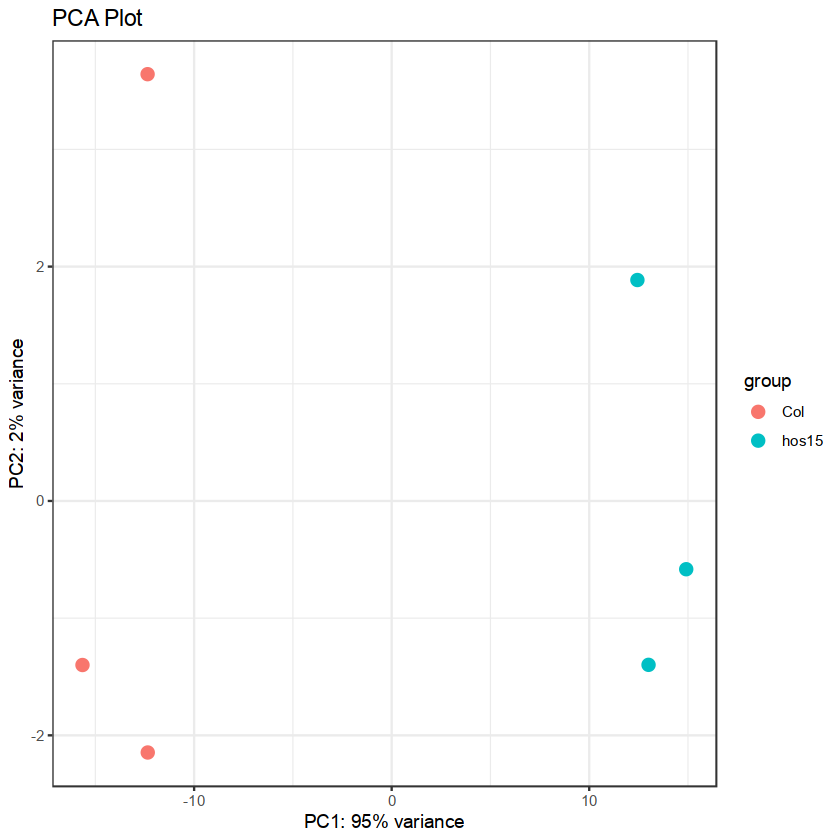

In [7]:
# Transform the data using variance stabilizing transformation (VST)
vst <- vst(dds, blind=FALSE)

# Create PCA plot
# First get the PCA data
pcaData <- plotPCA(vst, intgroup="group", returnData=TRUE)

# Make a nicer plot using ggplot2
library(ggplot2)

# Basic PCA plot
ggplot(pcaData, aes(x=PC1, y=PC2, color=group)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ", round(attr(pcaData, "percentVar")[1] * 100), "% variance")) +
  ylab(paste0("PC2: ", round(attr(pcaData, "percentVar")[2] * 100), "% variance")) +
  theme_bw() +
  ggtitle("PCA Plot")

In [8]:
# Get results comparing hos15 vs Col
# By default, the results function uses the last level alphabetically as the numerator
# and the first level as the denominator
# In this case: hos15 vs Col (hos15/Col)
res <- results(dds, contrast=c("group", "hos15", "Col"))

# Convert to a data frame and add gene names
res_df <- as.data.frame(res)
res_df$gene <- rownames(res_df)

# Add a column for significance
res_df$significant <- ifelse(res_df$padj < 0.05, "Yes", "No")

# Sort by adjusted p-value
res_df <- res_df[order(res_df$padj), ]

# Summary of results
summary(res)

# Get significant genes (padj < 0.05)
sig_genes <- subset(res_df, padj < 0.05)




out of 20696 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2004, 9.7%
LFC < 0 (down)     : 1905, 9.2%
outliers [1]       : 1, 0.0048%
low counts [2]     : 4013, 19%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [9]:
res

log2 fold change (MLE): group hos15 vs Col 
Wald test p-value: group hos15 vs Col 
DataFrame with 20696 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat    pvalue      padj
          <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
AT1G01010   2.99639       0.547346  1.112045  0.492198  0.622579        NA
AT1G01020  54.90431      -0.326274  0.270259 -1.207265  0.227330  0.487884
AT1G01030   2.81460      -0.819763  1.061002 -0.772630  0.439741        NA
AT1G01040  30.50095       0.131505  0.343702  0.382612  0.702007  0.869773
AT1G01050  70.46951       0.166707  0.229447  0.726562  0.467494  0.721704
...             ...            ...       ...       ...       ...       ...
AT5G67600 681.55903      0.1779237  0.111737  1.592346  0.111307  0.308884
AT5G67610  24.34819     -0.1713035  0.409357 -0.418470  0.675604  0.856741
AT5G67620   6.61210      0.0719185  0.704669  0.102060  0.918709  0.968802
AT5G67630  31.11523      0.5383776  0.337389  1.5957

In [10]:
# Write results to file (optional)
write.csv(res_df, "generated_data/hos15_vs_Col_results.csv", )

In [11]:
#save Radata
saveRDS(res_df, file = "generated_data/hos15_vs_Col_results.rds")

## Zhang 2019

In [12]:
library(readxl)

acd6 <- read_excel("downloaded_data/Zhang2019_acd6-1_GSE115680_LUX_RNAseq_RPKM.xlsx",
                   sheet = "RPKM",
#                  skip = 7,  # Skip the merged cells header
                  ) # Handle NA values appropriately 
acd6

New names:
• `` -> `...8`


GeneID,S1-1,S1-2,S1-3,S2-1,S2-2,S2-3,...8,S3-1,S3-2,⋯,S5-1,S5-2,S5-3,S6-1,S6-2,S6-3,S7-2,S7-3,S8-2,S8-3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AT1G01010.1,4.05124434,4.0916438,4.1748425,7.0429115,5.33753082,4.6655116,1.3838551,21.64334865,14.4382908,⋯,12.6664150,8.8653442,10.9313757,7.1890311,7.364625,6.79659151,15.8586047,13.66570085,11.8439468,12.7038290
AT1G01020.1,20.53618575,19.6414791,20.4929485,19.3760978,17.20835367,20.3879065,0.9390437,19.62580431,15.4023972,⋯,21.6743661,17.4927934,22.2923042,20.5447277,17.062000,20.48313952,17.2242798,17.04812662,17.5660409,18.0236066
AT1G01030.1,4.57518163,4.0230897,5.0690079,3.9611580,4.40416502,3.7758225,0.8883367,2.11739549,2.5432021,⋯,5.9887390,5.3419013,5.8694064,6.3556032,3.710479,3.93002410,1.6597561,1.83380283,1.9345013,1.8423305
AT1G01040.1,9.53754427,8.6891078,9.2958590,9.7202761,8.14446966,10.0918839,1.0157732,11.40163692,12.2371963,⋯,10.8510933,8.3875217,10.0844030,9.3897123,9.816440,9.14116403,13.7264434,13.00840768,12.1605747,14.1975199
AT1G01050.1,125.13209638,130.0661632,137.8511580,130.6827404,135.28983973,135.9338639,1.0225341,139.08502276,132.6650051,⋯,139.8313376,161.7333548,156.7591489,151.0050125,142.539719,138.74586325,107.6492219,116.99158230,117.4986703,122.7108736
AT1G01060.1,185.79909618,178.7780435,178.2696185,117.9339283,103.97994775,107.4763906,0.6067832,207.63896699,198.3605150,⋯,0.6656215,0.8326678,0.9618101,1.1773279,1.634050,0.93600972,1.4348012,1.05683901,1.5528582,1.7063897
AT1G01070.1,15.63887843,13.7038866,15.8568389,12.0159534,9.75468596,11.2589662,0.7307499,15.21188083,15.5910104,⋯,8.3805257,7.4762055,9.4476308,5.8988841,12.703963,9.43063891,10.4313368,10.19280388,9.6983469,9.6378384
AT1G01080.1,69.49517931,65.5601899,62.5662265,61.0885608,62.45274162,67.1305278,0.9648330,37.52508324,36.7998754,⋯,93.2135675,93.5484170,86.8317408,98.1359806,81.127380,93.83577030,55.0213947,60.62522578,70.7784270,54.1582046
AT1G01090.1,150.65151747,152.7231000,142.6194572,122.4026192,144.09259593,142.5034132,0.9170495,89.74432664,96.5683196,⋯,116.2012655,134.3259322,131.2303998,126.0441150,104.633976,123.85710430,81.4840930,82.58318808,86.1587106,87.8778776


In [13]:
library(tidyverse)

acd6_counts <- acd6 %>% 
  dplyr::select(GeneID, matches("S(1|3|5|7)-\\d"))  %>% tibble::column_to_rownames("GeneID")
acd6_counts %>% sample_n(5)

,S1-1,S1-2,S1-3,S3-1,S3-2,S3-3,S5-1,S5-2,S5-3,S7-2,S7-3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AT3G29300.1,0.4651629,0.1227094,0.3447412,0.00000,0.21332,0.5104161,0.2679074,0.00000,0.2524703,0.00000,0.00000
AT2G28430.1,44.2743132,42.7485174,41.7484254,46.82226,42.99638,45.7237880,71.6652428,62.00302,64.3945984,54.40169,49.89965
AT4G17490.1,10.4645216,17.1663027,22.1584532,25.91651,28.39040,29.9125488,39.7071027,93.38314,72.7382026,73.61402,72.20062
AT3G01440.1,28.8274711,35.0526790,37.4993140,14.50197,13.11677,10.5027932,91.7055686,98.41632,93.6333422,28.65923,36.51901
AT3G56360.1,334.7940410,314.2198718,337.3454605,394.38337,347.06069,379.9677178,522.4824968,508.21977,535.7840003,359.13360,427.42815


In [14]:
sample_data_acd6 <- data.frame(
    sample_name = c("S1-1", "S1-2", "S1-3", "S3-1", "S3-2", "S3-3", "S5-1", "S5-2", "S5-3", "S7-2", "S7-3"),
    group = c("WT_9am", "WT_9am", "WT_9am", "acd6_9am", "acd6_9am", "acd6_9am", "WT_9pm", "WT_9pm", "WT_9pm", "acd6_9pm", "acd6_9pm")
    ) 
rownames(sample_data_acd6) <- sample_data_acd6$sample_name
sample_data_acd6

,sample_name,group
,<chr>,<chr>
S1-1,S1-1,WT_9am
S1-2,S1-2,WT_9am
S1-3,S1-3,WT_9am
S3-1,S3-1,acd6_9am
S3-2,S3-2,acd6_9am
S3-3,S3-3,acd6_9am
S5-1,S5-1,WT_9pm
S5-2,S5-2,WT_9pm
S5-3,S5-3,WT_9pm


In [15]:
# Load required libraries
library(edgeR)
library(limma)

Warning message:
“package ‘edgeR’ was built under R version 4.3.2”
Loading required package: limma

Warning message:
“package ‘limma’ was built under R version 4.3.2”

Attaching package: ‘limma’


The following object is masked from ‘package:DESeq2’:

    plotMA


The following object is masked from ‘package:BiocGenerics’:

    plotMA




In [16]:
# First, let's check the dimensions of your data
dim(acd6_counts)  # This will show rows x columns of your count matrix
dim(sample_data_acd6)  # This will show rows x columns of your sample data

# Let's also look at the first few rows of each
head(acd6_counts)
sample_data_acd6

[1] 25218    11

[1] 11  2

,S1-1,S1-2,S1-3,S3-1,S3-2,S3-3,S5-1,S5-2,S5-3,S7-2,S7-3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AT1G01010.1,4.051244,4.091644,4.174843,21.643349,14.438291,15.558789,12.6664150,8.8653442,10.9313757,15.858605,13.665701
AT1G01020.1,20.536186,19.641479,20.492949,19.625804,15.402397,18.315847,21.6743661,17.4927934,22.2923042,17.224280,17.048127
AT1G01030.1,4.575182,4.023090,5.069008,2.117395,2.543202,1.217037,5.9887390,5.3419013,5.8694064,1.659756,1.833803
AT1G01040.1,9.537544,8.689108,9.295859,11.401637,12.237196,12.052368,10.8510933,8.3875217,10.0844030,13.726443,13.008408
AT1G01050.1,125.132096,130.066163,137.851158,139.085023,132.665005,130.254359,139.8313376,161.7333548,156.7591489,107.649222,116.991582
AT1G01060.1,185.799096,178.778044,178.269619,207.638967,198.360515,198.632857,0.6656215,0.8326678,0.9618101,1.434801,1.056839


,sample_name,group
,<chr>,<chr>
S1-1,S1-1,WT_9am
S1-2,S1-2,WT_9am
S1-3,S1-3,WT_9am
S3-1,S3-1,acd6_9am
S3-2,S3-2,acd6_9am
S3-3,S3-3,acd6_9am
S5-1,S5-1,WT_9pm
S5-2,S5-2,WT_9pm
S5-3,S5-3,WT_9pm


In [31]:
# Convert data matrix to log2 scale
log2_counts <- log2(acd6_counts + 1)  # Add 1 to avoid log(0)

# Create design matrix with proper factors
sample_data_acd6$group <- factor(sample_data_acd6$group, 
                                levels=c("WT_9am", "acd6_9am", "WT_9pm", "acd6_9pm"))

# Create design matrix
design <- model.matrix(~0 + group, data=sample_data_acd6)
colnames(design) <- c("WT_9am", "acd6_9am", "WT_9pm", "acd6_9pm")

# Fit linear model
fit <- lmFit(log2_counts, design)

# Create contrasts for both comparisons
contrasts <- makeContrasts(
    AM = acd6_9am - WT_9am,
    PM = acd6_9pm - WT_9pm,
    levels = c("WT_9am", "acd6_9am", "WT_9pm", "acd6_9pm")
)

# Fit contrasts and compute statistics
fit2 <- contrasts.fit(fit, contrasts)
fit2 <- eBayes(fit2)

# Get results for morning comparison
AM_results <- topTable(fit2, coef="AM", n=Inf)
AM_results$gene_id <- rownames(AM_results)

# Get results for evening comparison
PM_results <- topTable(fit2, coef="PM", n=Inf)
PM_results$gene_id <- rownames(PM_results)

# Add significance thresholds
AM_results$significant <- AM_results$adj.P.Val < 0.05 & abs(AM_results$logFC) > 1
PM_results$significant <- PM_results$adj.P.Val < 0.05 & abs(AM_results$logFC) > 1

# Print summaries
cat("\nMorning comparison (acd6_9am vs WT_9am):\n")
cat("Total significant genes:", sum(AM_results$significant), "\n")
cat("Up-regulated:", sum(AM_results$significant & AM_results$logFC > 0), "\n")
cat("Down-regulated:", sum(AM_results$significant & AM_results$logFC < 0), "\n")

cat("\nEvening comparison (acd6_9pm vs WT_9pm):\n")
cat("Total significant genes:", sum(PM_results$significant), "\n")
cat("Up-regulated:", sum(PM_results$significant & PM_results$logFC > 0), "\n")
cat("Down-regulated:", sum(PM_results$significant & PM_results$logFC < 0), "\n")

# Save results
saveRDS(AM_results, "generated_data/acd6_9am_vs_WT_9am_results.rds")
saveRDS(PM_results, "generated_data/acd6_9pm_vs_WT_9pm_results.rds")

Warning message:
“Zero sample variances detected, have been offset away from zero”



Morning comparison (acd6_9am vs WT_9am):
Total significant genes: 3992 
Up-regulated: 2871 
Down-regulated: 1121 

Evening comparison (acd6_9pm vs WT_9pm):
Total significant genes: 3747 
Up-regulated: 1835 
Down-regulated: 1912 


In [42]:
PM_results <-  PM_results  %>% dplyr::select(gene_id,logFC ) %>% dplyr::rename(acd6_9pm_l2FC = logFC)

In [43]:
AM_results <-  AM_results %>% dplyr::select(gene_id,logFC ) %>% dplyr::rename(acd6_9am_l2FC = logFC)

In [45]:
acd6_results <- AM_results %>% 
    left_join( PM_results, by = "gene_id")
acd6_results
acd6_results %>% saveRDS("generated_data/acd6_results.rds")

gene_id,acd6_9am_l2FC,acd6_9pm_l2FC
<chr>,<dbl>,<dbl>
AT4G09770.1,3.4593892,2.4771283
AT1G52510.1,-1.4290828,-1.0507537
AT3G12220.1,3.7411211,1.6903636
AT3G20770.1,1.1288287,0.4718403
AT3G19720.1,-1.3975203,-1.1825555
AT1G32440.1,-1.2299846,-0.6356048
AT1G15410.1,-2.2606618,-1.0824392
AT3G46780.1,-1.5471041,-1.4194415
AT4G01150.1,-1.4934881,-1.0900974


In [46]:
countData_Saile <- readRDS('../../donghui_d1/All_mRNA_seqs/helperless_Saile_2020/cleandata/countData_clean_Saile.RDS') %>% as.data.frame
countData_Saile

,A10Col.4h.M1.3,A10Col.8h.EV.1,A11Col.4h.T2.3,A11Col.8h.S4.1,A12Col.8h.EV.3,A12Col.8h.M1.1,A12Col.8h.S4.2,A1Col.30m.EV.1,A1Col.8h.M1.2,A1Col.8h.S4.3,⋯,H6ADR1.T0.2,H7ADR1.4h.EV.2,H7ADR1.4h.S4.1,H7ADR1.T0.3,H8ADR1.4h.EV.3,H8ADR1.4h.M1.1,H8ADR1.4h.S4.2,H9ADR1.4h.M1.2,H9ADR1.4h.S4.3,H9ADR1.4h.T2.1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
AT1G01010,289,286,223,521,217,272,236,65,309,168,⋯,18,241,113,69,389,65,254,149,330,158
AT1G01020,41,74,45,88,55,49,34,41,45,53,⋯,56,68,62,75,53,40,50,43,42,40
AT1G01030,33,27,44,59,47,34,18,16,87,5,⋯,11,61,39,15,65,20,57,53,69,43
AT1G01040,137,477,217,658,410,156,255,457,218,353,⋯,247,293,371,503,288,137,234,132,276,239
AT1G01050,43,126,93,186,92,41,49,176,53,51,⋯,97,70,174,232,104,33,82,66,85,96
AT1G01060,61,1,64,10,13,3,2,1658,21,4,⋯,1078,31,17,1355,50,8,45,36,20,4
AT1G01070,8,70,14,69,39,20,27,15,12,24,⋯,23,17,30,31,19,2,21,4,46,17
AT1G01080,24,51,73,86,40,17,34,381,39,14,⋯,267,47,151,458,63,30,83,37,34,74
AT1G01090,200,456,425,708,315,217,258,700,303,146,⋯,526,370,662,1269,427,148,389,345,455,454


In [47]:
Mine_countData <- read.csv('../../donghui_d1/All_mRNA_seqs/Mine_2018_Avr_Mock/Avr_Mock_countData.csv', row.names = 1)
colnames(Mine_countData) <- colnames(Mine_countData) %>% str_replace('\\.', '_')
Mine_countData

,Rpt_1h_r1,Rpt_1h_r2,Rpt_1h_r3,Rpt_2h_r1,Rpt_2h_r2,Rpt_2h_r3,Rpt_3h_r1,Rpt_3h_r2,Rpt_3h_r3,Rpt_4h_r1,⋯,Mock_12h_r3,Mock_16h_r1,Mock_16h_r2,Mock_16h_r3,Mock_20h_r1,Mock_20h_r2,Mock_20h_r3,Mock_24h_r1,Mock_24h_r2,Mock_24h_r3
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
AT1G01010,176,214,247,566,1523,1258,956,917,1124,511,⋯,446,396,310,506,124,292,172,185,247,184
AT1G01020,285,335,365,394,572,541,349,296,325,258,⋯,221,170,217,185,176,207,180,163,183,165
AT1G03987,4,6,5,7,8,19,2,3,9,0,⋯,0,2,1,0,1,0,2,3,3,0
AT1G01030,196,279,272,136,473,433,204,107,223,43,⋯,81,59,60,63,46,82,59,69,64,39
AT1G01040,589,947,708,1444,1775,1473,1902,1476,1467,1466,⋯,1552,1306,1360,1311,790,949,896,902,1068,831
AT1G03993,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AT1G01046,4,8,8,14,9,11,12,6,12,7,⋯,10,8,12,4,4,3,6,10,4,2
AT1G01050,429,534,521,985,855,999,1211,1263,1130,1538,⋯,1994,1573,1967,1604,864,1214,1105,1355,872,895
AT1G03997,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1


## ka120 Jia et al., 2021

In [52]:
library(readxl)

ka120 <- read_excel("downloaded_data/ka120_GSE147682_Raw_counts.xlsx",
                   sheet = 1,
                  ) # Handle NA values appropriately 

In [53]:
ka120 <- ka120 %>% tibble::column_to_rownames("gene_id")
ka120 %>% sample_n(10)

,Col-0 rep1,Col-0 rep2,Col-0 rep3,ka120 rep1,ka120 rep2,ka120 rep3,ka120 ndr1 rep1,ka120 ndr1 rep2,ka120 ndr1 rep3,ka120 pad4 rep1,ka120 pad4 rep2,ka120 pad4 rep3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AT4G37040,5082,5350,5574,4162,4507,4496,5041,4219,5058,4808,4979,4766
AT1G78240,3127,2967,3258,5272,5892,5416,5122,4266,5231,4484,4419,4261
AT2G41910,0,0,0,0,0,0,0,0,0,0,0,0
AT1G26850,11082,9996,13497,11586,12497,12222,12592,9950,9296,10834,10657,11837
AT1G17750,152,192,150,268,310,197,281,207,264,306,190,278
AT5G11390,690,648,793,1095,1352,1000,985,851,965,955,923,737
AT1G04527,0,0,0,0,0,0,0,0,1,0,0,4
AT1G63770,16729,17844,20333,18888,21027,17387,17559,15235,16925,15388,15970,16608
AT5G08070,355,370,495,354,327,452,420,315,342,314,283,254


In [54]:
names(ka120)

[1] "Col-0 rep1"      "Col-0 rep2"      "Col-0 rep3"      "ka120 rep1"     
 [5] "ka120 rep2"      "ka120 rep3"      "ka120 ndr1 rep1" "ka120 ndr1 rep2"
 [9] "ka120 ndr1 rep3" "ka120 pad4 rep1" "ka120 pad4 rep2" "ka120 pad4 rep3"

In [55]:
sample_data <- data.frame(
    sample_name = c('Col-0 rep1','Col-0 rep2','Col-0 rep3','ka120 rep1','ka120 rep2','ka120 rep3','ka120 ndr1 rep1','ka120 ndr1 rep2','ka120 ndr1 rep3','ka120 pad4 rep1','ka120 pad4 rep2','ka120 pad4 rep3'),
    group = c("Col", "Col", "Col", "ka120", "ka120", "ka120", "ka120 ndr1", "ka120 ndr1", "ka120 ndr1", "ka120 pad4", "ka120 pad4", "ka120 pad4")
    ) 
rownames(sample_data) <- sample_data$sample_name
sample_data

,sample_name,group
,<chr>,<chr>
Col-0 rep1,Col-0 rep1,Col
Col-0 rep2,Col-0 rep2,Col
Col-0 rep3,Col-0 rep3,Col
ka120 rep1,ka120 rep1,ka120
ka120 rep2,ka120 rep2,ka120
ka120 rep3,ka120 rep3,ka120
ka120 ndr1 rep1,ka120 ndr1 rep1,ka120 ndr1
ka120 ndr1 rep2,ka120 ndr1 rep2,ka120 ndr1
ka120 ndr1 rep3,ka120 ndr1 rep3,ka120 ndr1


In [56]:
dds <- DESeqDataSetFromMatrix(countData = ka120,
                             colData = sample_data,
                             design = ~ group)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [57]:
dds

class: DESeqDataSet 
dim: 34262 12 
metadata(1): version
assays(1): counts
rownames(34262): AT1G06623 AT4G22890 ... AT1G76900 AT1G09477
rowData names(0):
colnames(12): Col-0 rep1 Col-0 rep2 ... ka120 pad4 rep2 ka120 pad4 rep3
colData names(2): sample_name group

In [58]:
# Run DESeq analysis
dds <- DESeq(dds)

# Get results for ka120 vs Col comparison
# By default, the comparison will be done using the last level vs the first level alphabetically
# Here we'll explicitly specify the comparison we want
res_ka120_vs_col <- results(dds, contrast=c("group", "ka120", "Col"))

# Get a summary of the results
summary(res_ka120_vs_col)

# Convert to a data frame and add gene names
res_ka120_vs_col_df <- as.data.frame(res_ka120_vs_col)
res_ka120_vs_col_df$gene_id <- rownames(res_ka120_vs_col_df)

# Sort by adjusted p-value
res_ka120_vs_col_df <- res_ka120_vs_col_df[order(res_ka120_vs_col_df$padj),]

# View the top differentially expressed genes
head(res_ka120_vs_col_df)

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing




out of 27379 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 7154, 26%
LFC < 0 (down)     : 6621, 24%
outliers [1]       : 28, 0.1%
low counts [2]     : 3143, 11%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSRNA049494572,36623.169,-13.293871,0.34224807,-38.84279,0.000000e+00,0.000000e+00,ENSRNA049494572
AT1G21310,8087.634,5.633197,0.15261624,36.91086,3.094063e-298,3.745054e-294,AT1G21310
AT2G01010,7932.969,11.901298,0.32461599,36.66270,2.871829e-294,2.317375e-290,AT2G01010
AT1G23310,74133.149,-2.762559,0.08254801,-33.46609,1.501845e-245,9.089163e-242,AT1G23310
AT1G51110,6295.522,-1.889741,0.06180358,-30.57657,2.508278e-205,1.214408e-201,AT1G51110
AT3G45860,4096.930,4.675777,0.15824879,29.54700,7.176806e-192,2.895602e-188,AT3G45860


In [61]:
res_ka120_vs_col_df %>% saveRDS(file = "generated_data/ka120_vs_Col_results.rds")